# Latin Authorship Attribution
<hr>
This is the notebook for Rufus Behr's CS4040 Mini-Project


### Module Imports

In [2]:
import numpy as np
import plot
from Data import dataExp
%matplotlib inline
from matplotlib import pyplot as plt
import LatinBERT
from LatinBERT.gen_berts import LatinBERT
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning)
    from cltk.tokenizers.lat.lat import LatinWordTokenizer as WordTokenizer
    from cltk.tokenizers.lat.lat import LatinPunktSentenceTokenizer as SentenceTokenizer
from cltk.embeddings.embeddings import Word2VecEmbeddings as W2VE


2022-12-01 22:40:58.094775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 22:40:58.453449: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-01 22:40:58.453476: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-01 22:40:59.604010: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

## Data Preprocessing:
The data has already been preprocessed and stored in the corpus.pickle file.
text_corpus.pickle contains a plaintext version of the corpus, as for the semantic embeddings further tokenization will either not take place (as is the case for Word2Vec) or happens within the model (as is the case for LatinBERT)

In [3]:
CI = dataExp.CorpusInterface(corpus_name="text_corpus.pickle", shouldTokenize = False)
preprocessed_CI = dataExp.CorpusInterface(corpus_name="corpus.pickle", shouldTokenize = True)

Found the existing corpus
abbofloracensis had 1 pieces of work with a total of 34398 characters of text
abelard had 1 pieces of work with a total of 15483 characters of text
acticussincerius had 1 pieces of work with a total of 15967 characters of text
addison had 1 pieces of work with a total of 7390 characters of text
adso had 1 pieces of work with a total of 13551 characters of text
aelredus had 1 pieces of work with a total of 118173 characters of text
agnes had 1 pieces of work with a total of 74784 characters of text
alanus had 1 pieces of work with a total of 195061 characters of text
albericodamarcellise had 1 pieces of work with a total of 172 characters of text
albertanus had 1 pieces of work with a total of 40604 characters of text
albertofaix had 1 pieces of work with a total of 118729 characters of text
alcuin had 1 pieces of work with a total of 70404 characters of text
aleandrogerolamo had 1 pieces of work with a total of 10197 characters of text
alfonsi had 1 pieces of 

Found the existing corpus
abbofloracensis had 1 pieces of work with a total of 4630 characters of text
abelard had 1 pieces of work with a total of 2258 characters of text
acticussincerius had 1 pieces of work with a total of 894 characters of text
addison had 1 pieces of work with a total of 430 characters of text
adso had 1 pieces of work with a total of 1961 characters of text
aelredus had 1 pieces of work with a total of 16943 characters of text
agnes had 1 pieces of work with a total of 10165 characters of text
alanus had 1 pieces of work with a total of 27945 characters of text
albericodamarcellise had 1 pieces of work with a total of 26 characters of text
albertanus had 1 pieces of work with a total of 19166 characters of text
albertofaix had 1 pieces of work with a total of 11592 characters of text
alcuin had 1 pieces of work with a total of 153 characters of text
aleandrogerolamo had 1 pieces of work with a total of 1555 characters of text
alfonsi had 1 pieces of work with a t

### Initial Data Exploratory Analysis

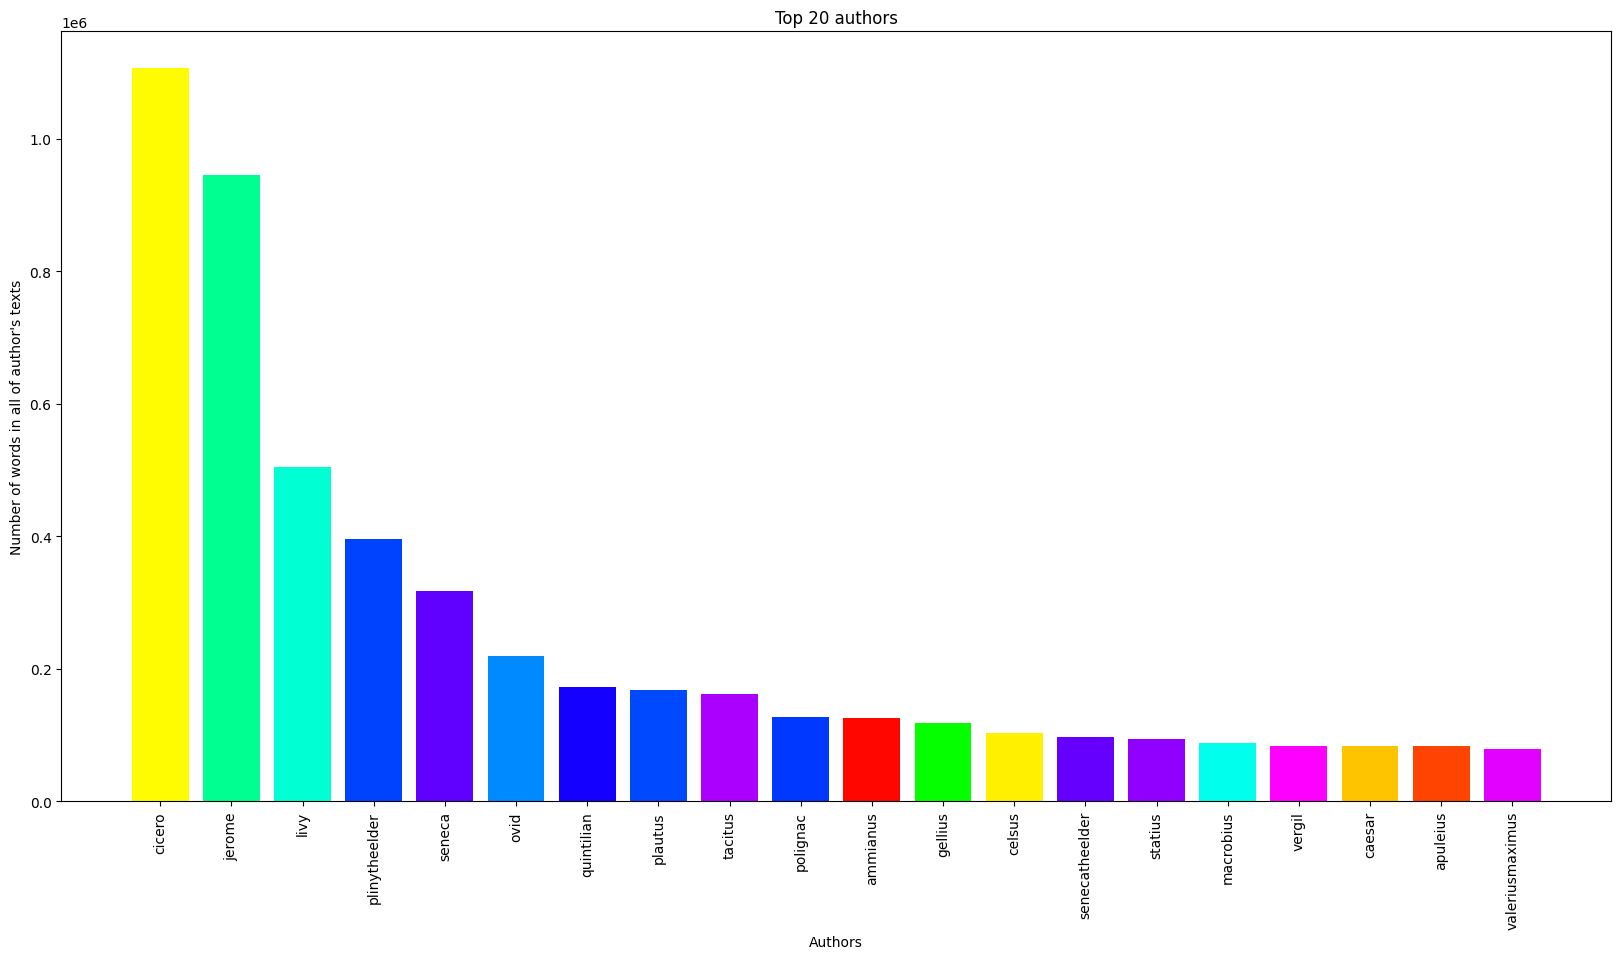

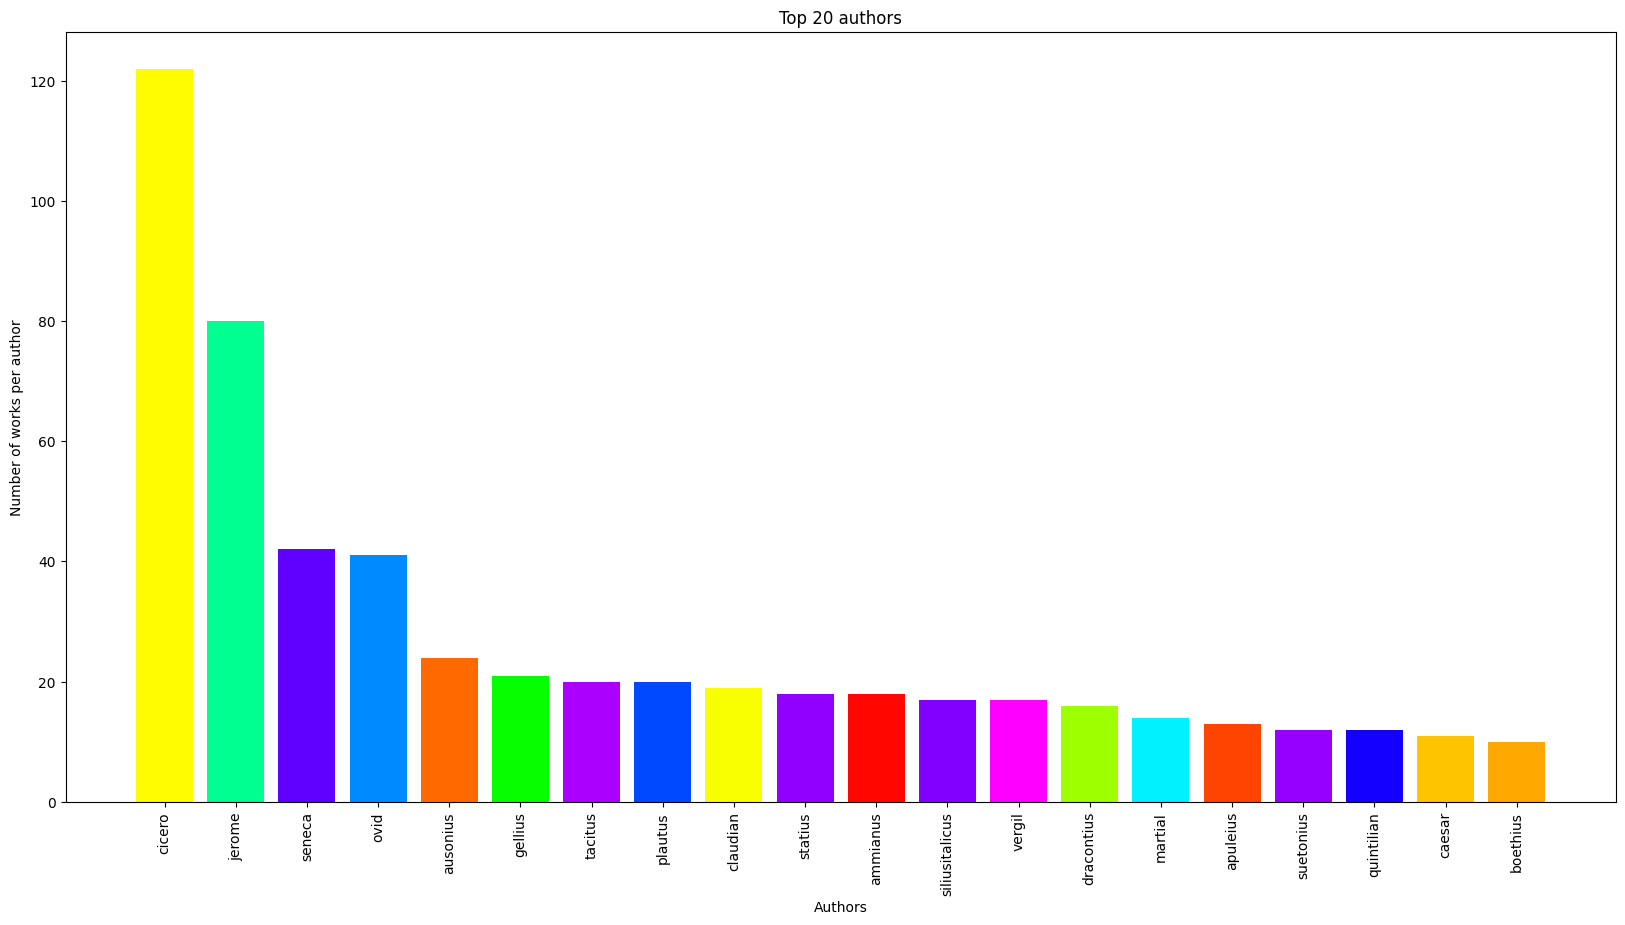

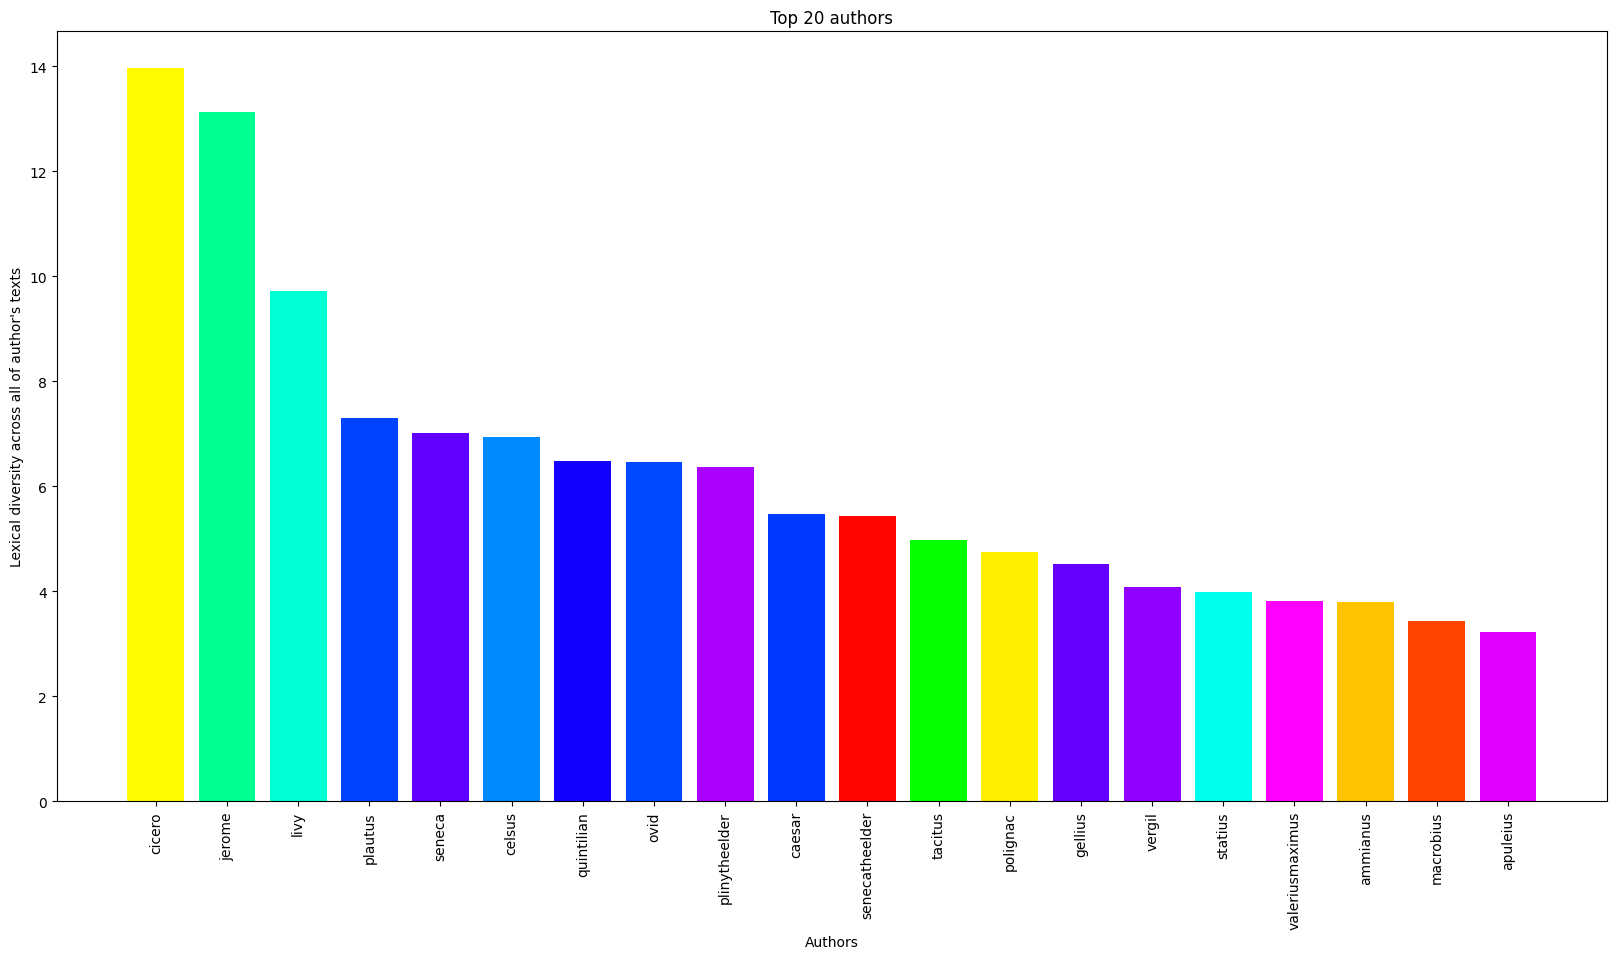

In [4]:
topAuthorsByTextLength, authors = plot.author_text_length_plot(preprocessed_CI, n_authors=20)
topAuthorsByWorkCount = plot.author_work_count_plot(preprocessed_CI, n_authors=20)
plot.author_lexical_diversity_plot(preprocessed_CI, authors)

## Experiments
Research Questions
1. Are the styles of the Latin texts distinct enough to accurately classify by author? Additionally, how do the varying embeddings, both word and lemma, compare in encoding the semantic relation between documents to perform this task?
2. Is it possible to identify the most important stylometric features for authorship attribution? If so, what are they?

<hr> 

### Semantic 

To address the first research question ....

Let's load in our 2 models


In [9]:
tokenizerPath = 'LatinBERT/latin.subword.encoder'
bertPath = 'LatinBERT/latin_bert/'
lat_bert = LatinBERT(tokenizerPath=tokenizerPath, bertPath=bertPath)

w2v = W2VE("lat")
# will be necessary for the word2vec tokenizer
st = SentenceTokenizer()
wt = WordTokenizer()

Some weights of the model checkpoint at LatinBERT/latin_bert/ were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Before using word2vec's model, let's write a function that performs the equivalent of get_berts in gen_berts for CLTK's word2vec model.
The main difference is that in our retrieval of embeddings and authors instead of returning a list of of size 2 of respective embeddings and authors it returns a list the size of the sentences where each i details the sentence and the author as a list pair.

In [28]:
def get_word2vec_encodings(input_sents, authors):
    all_sents = []
    for i in range(len(input_sents)):
        sents = st.tokenize(input_sents[i])
        for sent in sents:
            encoded_sent = []
            words = wt.tokenize(sent)
            for word in words:
                encoded_word = w2v.get_word_vector(word)
                if encoded_word is not None:
                    encoded_sent.append((word, encoded_word))
            all_sents.append([encoded_sent, authors[i]])
    return all_sents

Let's now load in our desired data, currently I'm just looking at the top 50 (in terms of characters in text) authors.

In [7]:
initial_texts, initial_authors = CI.get_data(n_authors=20)
texts = []
authors = []
for i in range(len(initial_texts)):
    for j in range(len(initial_texts[i])):
        texts.append(initial_texts[i][j][0])
        authors.append(initial_authors[i])

And now we can create the sentence embeddings for both LatinBERT and word2vec

In [8]:
bert_embedded_sents = lat_bert.get_berts(texts, authors)

NameError: name 'lat_bert' is not defined